In [1]:
import numpy as np
from numpy import full, outer, trace, dot, vdot, pi, log2, exp, sin, cos, sqrt, sign, diag, linspace, arange, array, inf, zeros, eye, arccos, arcsin, arctan, mean, std, concatenate, kron, sign, ceil, log, cumsum
from numpy.random import uniform, normal
from scipy.linalg import eigh, norm, expm, sqrtm, svd, logm
from scipy.stats import sem
from scipy.optimize import minimize
from functools import reduce
# import qutip as qp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=True)

In [2]:
P0 = np.array([[1., 0.],
               [0., 0.]]) # |0><0|
P1 = np.array([[0., 0.],
               [0., 1.]]) # |1><1|
X = np.array([[0.,1.],
              [1.,0.]])
Y = np.array([[0.,-1.j],
              [1.j, 0.]])
Z = np.array([[1., 0.],
              [0.,-1.]])
I = np.array([[1.,0.],
              [0.,1.]])

In [3]:
def kron_A_N(A, N): # fast kron(A, eye(N))
    m,n = A.shape
    out = zeros((m, N, n, N), dtype=A.dtype)
    r = arange(N)
    out[:, r, :, r] = A
    out.shape = (m*N, n*N)
    return out
    
def kron_N_A(A, N): # fast kron(eye(N), A)
    m,n = A.shape
    out = zeros((N, m, N, n), dtype=A.dtype)
    r = np.arange(N)
    out[r, :, r, :] = A
    out.shape = (m*N, n*N)
    return out

def kron_A_I_diag(A, N):
    m = len(A)
    out = zeros((N, m), dtype=A.dtype)
    out[arange(N)] = A
    out = out.T.reshape(m*N)
    return out

def kron_I_A_diag(A, N):
    m = len(A)
    out = zeros((N, m), dtype=A.dtype)
    out[arange(N)] = A
    out = out.reshape(m*N)
    return out

In [4]:
def ising_ham(n_qubits, h, J=1, bc="closed"):
    d = 2**n_qubits
    Hx = zeros((d, d), dtype=complex)
    for q in range(n_qubits):
        X_op = [I]*q + [X] + [I]*(n_qubits-q-1)
        Hx = Hx + reduce(kron, X_op)
    Hzz = zeros((d, d), dtype=complex)
    for q in range(n_qubits-1):
        Hzz = Hzz + reduce(kron, [I]*q + [Z, Z] + [I]*(n_qubits-q-2))
    if bc == "closed" and n_qubits > 2:
        Hzz = Hzz + reduce(kron, [Z] + [I]*(n_qubits-2) + [Z])
    if n_qubits == 1: # lame
        Hzz = 1*Z
    return -J*(Hzz + h*Hx)

In [5]:
def partial_trace(dm, m=None, n=None, subsystem=0):
    """ Simple and fast, but cuts only in halves. """
    if (m is None) or (n is None): # cut in equal halves
        N = log2(len(dm))
        m = int(N / 2)
        n = int(N - m)
        m = 2**m
        n = 2**n
    if subsystem == 0:
        return trace(dm.reshape((m, n, m, n)), axis1=0, axis2=2)
    elif subsystem == 1:
        return trace(dm.reshape((m, n, m, n)), axis1=1, axis2=3)

In [6]:
def xz_rot(pars):
    """ xz-rotation """
    cos_par_0 = cos(pars[0])
    sin_par_0 = sin(pars[0])
    exp_par_1 = exp(1j * pars[1])
    return np.array([[exp_par_1.conjugate() * cos_par_0, -1j*exp_par_1.conjugate() * sin_par_0],
                     [        -1j*exp_par_1 * sin_par_0,                 exp_par_1 * cos_par_0]])

def cr_y(n_qubits, q1, q2, par):
    """ Controlled y-rotation """
    cry_1 = kron_N_A(P0, 2**q1)
    cry_1 = kron_A_N(cry_1, 2**(n_qubits - q1 -1))
    cos_par = cos(par)
    sin_par = sin(par)
    ry = array([[cos_par, -sin_par], [sin_par, cos_par]])
    if q2 > q1:
        op_l = kron_N_A(P1, 2**q1)
        op_l = kron_A_N(op_l, 2**(q2 - q1 - 1))
        op_r = kron_A_N(ry, 2**(n_qubits - q2 - 1))
        cry_2 = kron(op_l, op_r)
    else:
        op_l = kron_N_A(ry, 2**q2)
        op_l = kron_A_N(op_l, 2**(q1 - q2 - 1))
        op_r = kron_A_N(P1, 2**(n_qubits - q1 - 1))
        cry_2 = kron(op_l, op_r)
    return cry_1 + cry_2
    
def rxx(N, q1, q2, par):
    j, k = sorted([q1, q2])
    term_1 = diag(full(2**n_qubits, cos(par)))
    term_21 = kron_N_A(X, 2**j)
    term_21 = kron_A_N(term_21, 2**(k - j - 1))
    term_22 = kron_A_N(X, 2**(n_qubits - k - 1))
    term_2 = kron(term_21, term_22)
    term_2 = -1j*sin(par)*term_2
    return term_1 + term_2

def rzz(N, q1, q2, par):
    j, k = sorted([q1, q2])
    term_1 = diag(full(2**N, cos(par)))
    term_21 = kron_N_A(Z, 2**j)
    term_21 = kron_A_N(term_21, 2**(k - j - 1))
    term_22 = kron_A_N(Z, 2**(N - k - 1))
    term_2 = kron(term_21, term_22)
    term_2 = -1j*sin(par)*term_2
    return term_1 + term_2

def cx(n_qubits, q1, q2):
    """ CX gate """
    cx_1 = kron_N_A(P0, 2**q1)
    cx_1 = kron_A_N(cx_1, 2**(n_qubits - q1 -1))
    if q2 > q1:
        op_l = kron_N_A(P1, 2**q1)
        op_l = kron_A_N(op_l, 2**(q2 - q1 - 1))
        op_r = kron_A_N(X, 2**(n_qubits - q2 - 1))
        cx_2 = kron(op_l, op_r)
    else:
        op_l = kron_N_A(X, 2**q2)
        op_l = kron_A_N(op_l, 2**(q1 - q2 - 1))
        op_r = kron_A_N(P1, 2**(n_qubits - q1 - 1))
        cx_2 = kron(op_l, op_r)
    return cx_1 + cx_2

def cx_cascade(n_qubits):
    if n_qubits == 1:
        return eye(2)
    else:
        op_l = []
        for q in range(n_qubits - 1):
            op_l.append(cx(n_qubits, q, q + 1))
        if n_qubits > 2:
            op_l.append(cx(n_qubits, n_qubits - 1, 0))
        return reduce(dot, op_l)

def hea_cx_rzrx(n_qubits, n_layers, CXq, pars):
    """ Requires pre-computed chain of CX-gates, CXq=cx_cascade(n_qubits) """
    it = iter(pars)
    op = reduce(kron, [xz_rot([next(it), next(it)]) for q in range(n_qubits)])
    for l in range(n_layers):
        op = CXq@op
        op = reduce(kron, [xz_rot([next(it), next(it)]) for q in range(n_qubits)])@op        
    return op

def hea_cry_rzrx(n_qubits, n_layers, pars):
    it = iter(pars)
    op = reduce(kron, [xz_rot([next(it), next(it)]) for q in range(n_qubits)])
    for l in range(n_layers):
        for q in range(n_qubits - 1):
            op = cr_y(n_qubits, q, q+1, next(it))@op
        op = reduce(kron, [xz_rot([next(it), next(it)]) for q in range(n_qubits)])@op
    return op

def hea_rzz_rzrx(n_qubits, n_layers, pars):
    it = iter(pars)
    op = reduce(kron, [xz_rot([next(it), next(it)]) for q in range(n_qubits)])
    op = eye(2**n_qubits)
    for l in range(n_layers):
        for q in range(n_qubits - 1):
            op = rzz(n_qubits, q, q+1, next(it))@op
        op = rzz(n_qubits, 0, n_qubits-1, next(it))@op
        op = reduce(kron, [xz_rot([next(it), next(it)]) for q in range(n_qubits)])@op
    return op

In [7]:
def rand_ham(N):
    d = 2**N
    H = uniform(-1, 1, [d, d]) + 1j*uniform(-1, 1, [d, d])
    return (H + H.conj().T)/2

# Multipartition

In [12]:
def do_vqe_parts(H, L, R=None, parts=None, x0=None, method="SLSQP", options={}):
  # TODO: can also provide different L's for each part in parts

    N = int(log2(len(H)))

    if parts is None:
        parts = [N//2 + N%2, N//2] # equal bipartition
    if R is None:
        R = 2**min(parts) # minimal dimensionality among parts

    n_pars_ans_cs = cumsum([0] + [(2*p + 3*p*L) for p in parts]) # parts 
    statevecs_ini_list = [[array([0]*r + [1] + [0]*(2**p - r - 1)) for r in range(R)] for p in parts] # initial states for each part for each r
    
    fvals, fval_cont = [], [0] # auxiliary things
    def fun(x):        
        U_list = [hea_rzz_rzrx(parts[p], L, x[n_pars_ans_cs[p] : n_pars_ans_cs[p + 1]]) for p in range(len(parts))] # ansatz for each part
        statevecs_r = []
        for r in range(R):
            statevecs_rp = []
            for p in range(len(parts)):
                statevec_rp = U_list[p]@statevecs_ini_list[p][r]
                statevecs_rp.append(statevec_rp)
            statevecs_r.append(reduce(kron, statevecs_rp))
        statevec = sum([v*exp(1j*f)*statevec for v, f, statevec in zip(x[-2*R:-R], x[-R:], statevecs_r)])
        f = (statevec.conj().T@H@statevec).real
        fval_cont[0] = f
        return f
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\tIteration: %d | Function value: %.6f" %(len(fvals), fval_cont[0]), end="\r")
        return None
    
    constraints = ({'type': 'eq', 'fun': lambda x: sum(np.abs(x[-2*R:-R])**2) - 1})
    bounds = [(0, 2*pi)]*n_pars_ans_cs[-1] + [(0, 1)]*R + [(0, 2*pi)]*R # ansatz angles, amplitudes, phases
    if x0 is None:
        x_ans = uniform(0, 2*pi, n_pars_ans_cs[-1]) # ansatz angles
        # x_v = array([1/R**(1/R)]*R) # amplitudes 
        x_v = uniform(0, 1, R); x_v = x_v/sum(np.abs(x_v)**2) # amplitudes
        # x_f = array([pi/2]*R) # phases
        x_f = uniform(0, 2*pi, R) # phases
        x0 = concatenate([x_ans, x_v, x_f])
    
    optimization_result = minimize(fun=fun, x0=x0, constraints=constraints, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return array(fvals), optimization_result

## Ising Hamiltonian

/home/kardashin/anaconda3/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py:203: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)


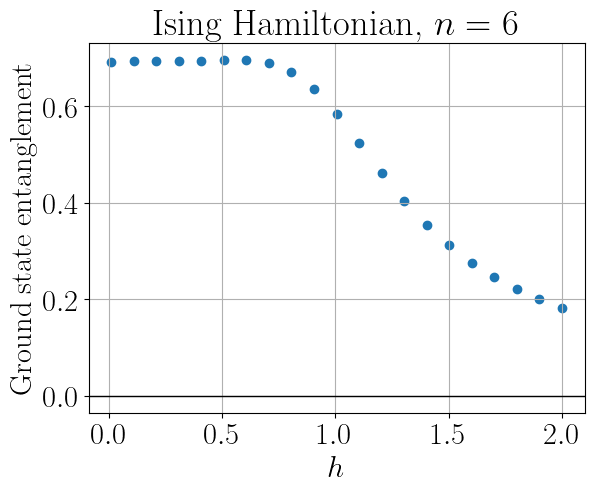

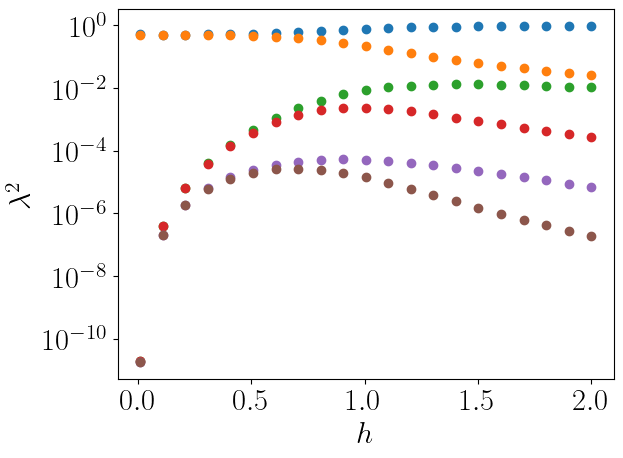

In [9]:
N = 6
hs = linspace(1e-2, 2, 21)
vn_ents = []
lambdas_gs = []
for h in hs:
    print("h=%.4f" %h, end="\r")
    H = ising_ham(N, h)
    vec_gs = eigh(H)[1][:,0]
    dm_gs = outer(vec_gs, vec_gs.conj().T)
    dm_gs_red = partial_trace(dm_gs)
    vn_ents.append(-trace(dm_gs_red@logm(dm_gs_red)).real)
    lambdas_gs.append(eigh(dm_gs_red)[0][::-1])

plt.scatter(hs, vn_ents)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel(r"$h$")
plt.ylabel(r"Ground state entanglement")
plt.title("Ising Hamiltonian, $n=%d$" %N )
plt.grid()
plt.show()

# for i in range(2**int(N/2)):
for i in range(6):#2**int(N/2)):
    plt.scatter(hs, array(lambdas_gs).T[i])
plt.xlabel(r"$h$")
plt.ylabel(r"$\lambda^2$")
plt.yscale("log")
plt.show()

In [16]:
N = 6
h = 0.5

H = ising_ham(N, h)
E_gs, E_ex = eigh(H)[0][0:2]

In [17]:
L = 4
n_runs = 50
R_min = 1
R_max = 3
parts = [3, 3]
method = "SLSQP"
options = {"maxiter": 10000}#, "ftol": 1e-9
energies = []
lambdas = []
for R in range(R_min, R_max + 1):
    print("R =", R)
    energies_r = []
    lambdas_r = []
    for i in range(n_runs):
        print("\ti = %d" %i)
        fvals, optimization_result = do_vqe_parts(H=H, L=L, R=R, parts=parts, method=method, options=options)
        print()
        print("\t\terror: %f" %(optimization_result.fun - E_gs))
        print("\t\tamplitudes:", optimization_result.x[-2*R:-R])
        print("\t\tphases    :", optimization_result.x[-R:])
        print()
        energies_r.append(optimization_result.fun)
        lambdas_r.append(optimization_result.x[-2*R:])
    print("\tminimum error: %f                                     " %(min(energies_r) - E_gs))
    print("\tamplitudes:", lambdas_r[np.argmin(energies_r)][:R])
    print("\tphases    :", lambdas_r[np.argmin(energies_r)][R:])
    print()
    energies.append(energies_r)
    lambdas.append(lambdas_r)

R = 1
	i = 0
		Iteration: 64 | Function value: -6.378912
		error: 0.005783
		amplitudes: [1.]
		phases    : [3.41588589]

	i = 1
		Iteration: 43 | Function value: -6.378952
		error: 0.005742
		amplitudes: [1.]
		phases    : [2.83738195]

	i = 2
		Iteration: 54 | Function value: -6.378925
		error: 0.005770
		amplitudes: [1.]
		phases    : [0.27934676]

	i = 3
		Iteration: 54 | Function value: -6.378892
		error: 0.005802
		amplitudes: [1.]
		phases    : [4.77288232]

	i = 4
		Iteration: 36 | Function value: -6.378952
		error: 0.005742
		amplitudes: [1.]
		phases    : [5.6901441]

	i = 5
		Iteration: 41 | Function value: -6.378947
		error: 0.005748
		amplitudes: [1.]
		phases    : [2.23321911]

	i = 6
		Iteration: 49 | Function value: -6.378947
		error: 0.005748
		amplitudes: [1.]
		phases    : [3.80551593]

	i = 7
		Iteration: 53 | Function value: -6.378936
		error: 0.005759
		amplitudes: [1.]
		phases    : [4.37493606]

	i = 8
		Iteration: 34 | Function value: -6.378931
		error: 0.00576

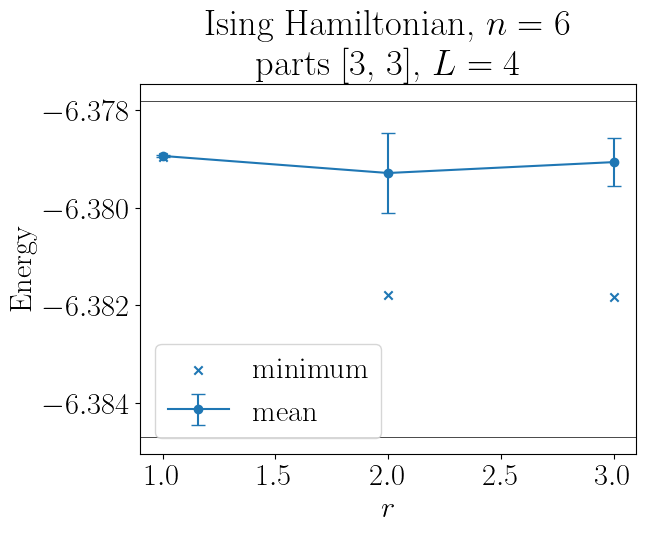

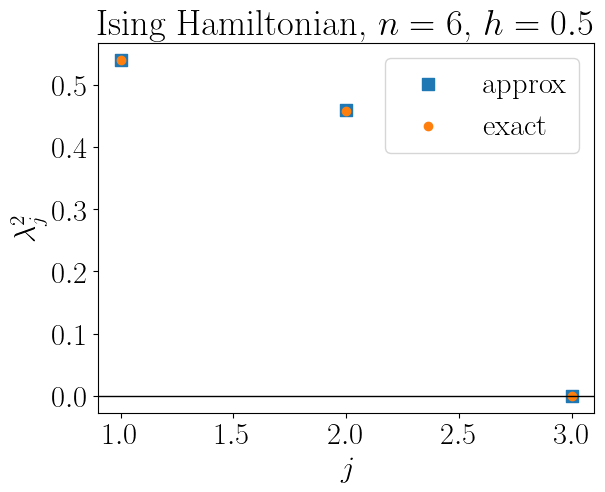

In [26]:
plt.errorbar(arange(R_min, R_max + 1), np.mean(energies, axis=1), yerr=np.std(energies, axis=1), marker="o", capsize=5, label="mean")
plt.scatter(arange(R_min, R_max + 1), np.min(energies, axis=1), marker="x", label="minimum")
plt.axhline(E_gs, color="black", linewidth=0.5)
plt.axhline(E_ex, color="black", linewidth=0.5)
# plt.axhline((vec_gs_trunc.conj().T@H@vec_gs_trunc).real, color="green", linewidth=1)
plt.xlabel(r"$r$")
plt.ylabel(r"Energy")
plt.title("Ising Hamiltonian, $n=%d$ \n parts %s, $L=%d$ " %(N, parts, L))
plt.legend(loc=3)
plt.show()

vec_gs = eigh(H)[1][:,0]
dm_gs = outer(vec_gs, vec_gs.conj().T)
dm_gs_red = partial_trace(dm_gs, n=2**min(parts), m=2**(N - min(parts)))
lambdas_gs = eigh(dm_gs_red)[0][::-1]
plt.scatter(arange(1, R_max + 1), np.sort(lambdas[-1][np.argmin(energies[-1])][-2*R_max:-R_max])[::-1]**2, s=75, marker="s", label="approx")
plt.scatter(arange(1, R_max + 1), lambdas_gs[:R_max], label="exact")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j^2$")
plt.title("Ising Hamiltonian, $n=%d$, $h=%.1f$" %(N, h))
plt.legend()
# plt.yscale("log")
plt.show()

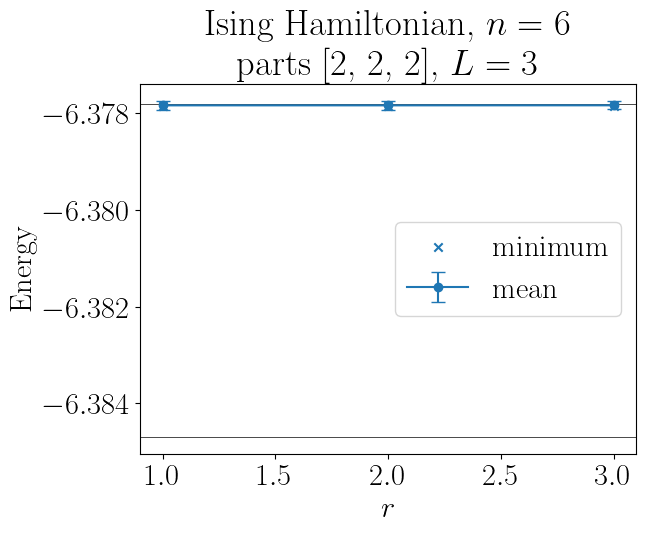

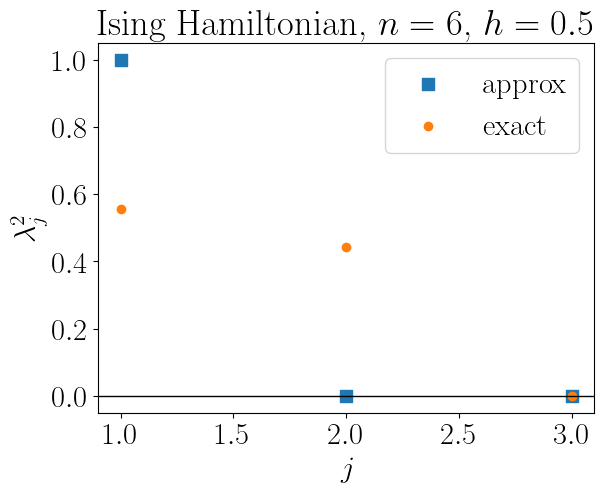

In [15]:
# 100 runs

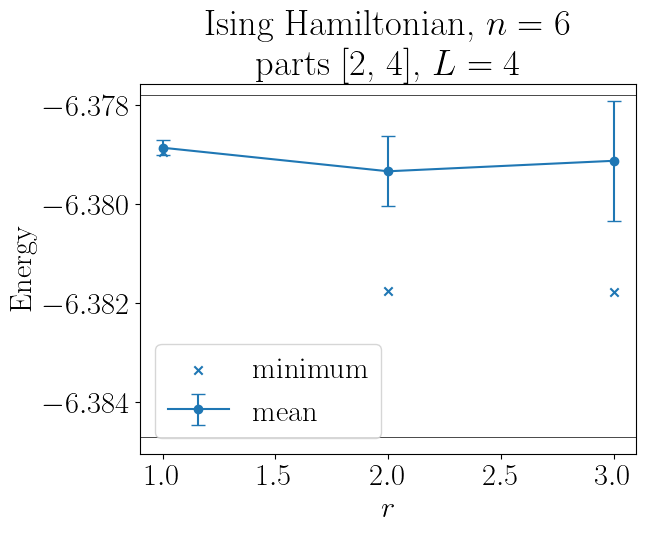

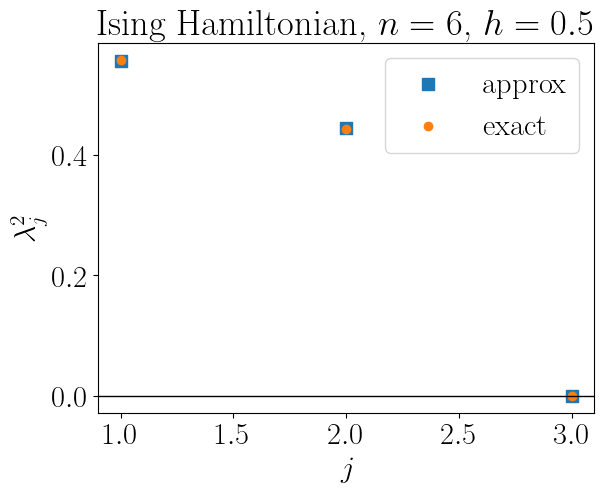

In [29]:
# 50 runs

## Random Hamiltonian

In [25]:
N = 6
h = 0.5

# H = ising_ham(N, h)
H = rand_ham(N)
# vec = sum([kron(vec, vec) for vec in eye(2**int(N/2))])/sqrt(2**(N/2))
# H = eye(2**N) - outer(vec, vec)
# H = diag(arange(1, 2**N + 1)) - outer(vec, vec)
E_gs, E_ex = eigh(H)[0][0:2]

In [37]:
L = 4
n_runs = 100
R_min = 1
R_max = 8 
parts = [3, 3] # [2, 2, 2]
options = {"maxiter": 10000}#, "ftol": 1e-9
energies = []
lambdas = []
for R in range(R_min, R_max + 1):
    print("R =", R)
    energies_r = []
    lambdas_r = []
    for i in range(n_runs):
        print("\ti = %d" %i)
        fvals, optimization_result = do_vqe_parts(H=H, L=L, R=R, parts=parts, options=options)
        print()
        print("\t\terror: %f" %(optimization_result.fun - E_gs))
        print("\t\tamplitudes:", optimization_result.x[-2*R:-R])
        print("\t\tphases    :", optimization_result.x[-R:])
        print()
        energies_r.append(optimization_result.fun)
        lambdas_r.append(optimization_result.x[-2*R:])
    print("\t\tminimum error: %f                                     " %(min(energies_r) - E_gs))
    print("\t\tamplitudes:", lambdas_r[np.argmin(energies_r)][:R])
    print("\t\tphases    :", lambdas_r[np.argmin(energies_r)][R:])
    print()
    energies.append(energies_r)
    lambdas.append(lambdas_r)

R = 1
i = 0
Iteration: 49 | Function value: -4.482837
error: 4.230106
lambdas: [1.         6.07656024]

i = 1
Iteration: 38 | Function value: -4.482837
error: 4.230105
lambdas: [1.        2.3574582]

i = 2
Iteration: 38 | Function value: -4.482837
error: 4.230105
lambdas: [1.         4.46224883]

i = 3
Iteration: 43 | Function value: -4.740598
error: 3.972342
lambdas: [1.        4.8872317]

i = 4
Iteration: 48 | Function value: -4.482837
error: 4.230105
lambdas: [1.         5.64477407]

i = 5
Iteration: 54 | Function value: -4.740600
error: 3.972342
lambdas: [1.         0.04046145]

i = 6
Iteration: 58 | Function value: -4.194751
error: 4.518192
lambdas: [1.         2.15313309]

i = 7
Iteration: 35 | Function value: -4.237316
error: 4.475627
lambdas: [1.         4.57986855]

i = 8
Iteration: 57 | Function value: -4.740601
error: 3.972342
lambdas: [1.         2.26754129]

i = 9
Iteration: 35 | Function value: -4.628876
error: 4.084059
lambdas: [1.         0.64736068]

i = 10
Iteration: 

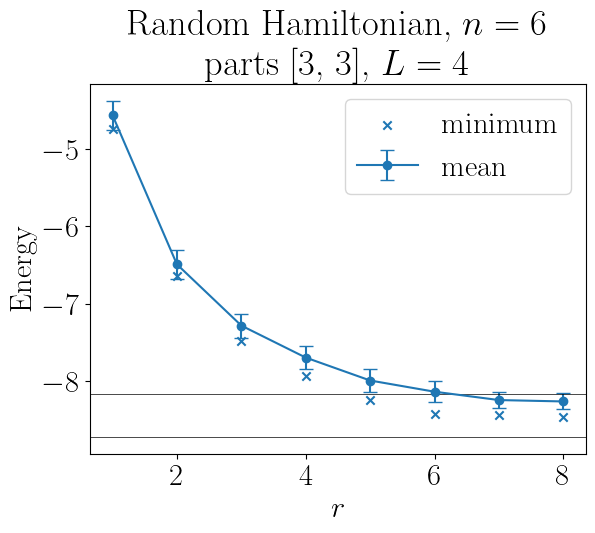

In [65]:
plt.errorbar(arange(R_min, R_max + 1), np.mean(energies, axis=1), yerr=np.std(energies, axis=1), marker="o", capsize=5, label="mean")
plt.scatter(arange(R_min, R_max + 1), np.min(energies, axis=1), marker="x", label="minimum")
plt.axhline(E_gs, color="black", linewidth=0.5)
plt.axhline(E_ex, color="black", linewidth=0.5)
# plt.axhline((vec_gs_trunc.conj().T@H@vec_gs_trunc).real, color="green", linewidth=1)
plt.xlabel(r"$r$")
plt.ylabel(r"Energy")
plt.title("Random Hamiltonian, $n=%d$ \n parts %s, $L=%d$ " %(N, parts, L))
plt.legend()
plt.show()

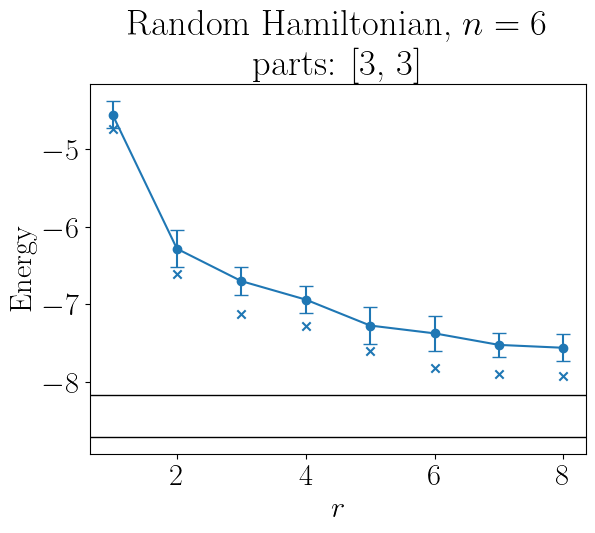

In [36]:
# 3 layers, 50 runs

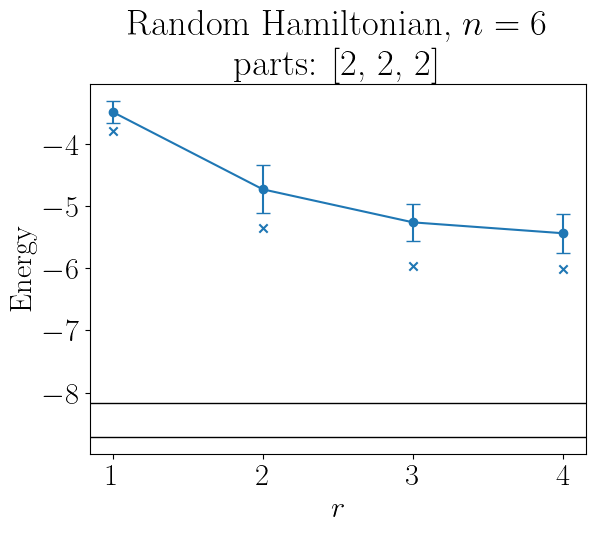

In [29]:
# 2 lyaers, 50 runs

# Bipartition

In [8]:
def do_vqe(H, L, R, P=2, method="SLSQP", x0=None, options={}):

    N = int(log2(len(H))/2)
    # n_pars_ans = (3*N - 1)*L + 2*N # CRy
    n_pars_ans = 3*N*L + 2*N # CRy
    # n_pars_ans = 3*N*L # CRy

    statevecs_ini = [array([0]*r + [1] + [0]*(2**N - r - 1)) for r in range(R)]
    
    fvals = []
    fval_cont = [0]

    def fun(x):
        U_p = [hea_rzz_rzrx(N, L, x[p*n_pars_ans : (p + 1)*n_pars_ans]) for p in range(P)]
        statevecs_r = []
        for r in range(R):
            statevecs_rp = []
            for p in range(P): # for further generalizations for P>2 partitions
                statevec_rp = U_p[p]@statevecs_ini[r]
                statevecs_rp.append(statevec_rp)
            statevecs_r.append(reduce(kron, statevecs_rp))
        statevec = sum([sqrt(lam)*statevec for lam, statevec in zip(x[-R:], statevecs_r)])
        f = (statevec.conj().T@H@statevec).real
        fval_cont[0] = f
        return f
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\t\tIteration: %d | Function value: %.6f" %(len(fvals), fval_cont[0]), end="\r")
        return None

    constraints = ({'type': 'eq', 'fun': lambda x: sum(x[-R:]) - 1})
    bounds = [(0, 2*pi)]*(1*P*n_pars_ans) + [(0.1, 1)]*R
    if x0 is None:
        x_ans = uniform(0, 2*pi, 1*P*n_pars_ans)
        # x_ans = normal(pi/4, 0.1, R*P*n_pars_ans)
        # x_r = uniform(0.1, 1, R); x_r = x_r/sum(x_r)
        x_r = array([1/R]*R)
        x0 = concatenate([x_ans, x_r])
    
    optimization_result = minimize(fun=fun, x0=x0, constraints=constraints, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return array(fvals), optimization_result

In [18]:
N = 6
hs = linspace(1e-2, 2, 21)
vn_ents = []
lambdas_gs = []
for h in hs:
    print("h=%.4f" %h, end="\r")
    H = ising_ham(N, h)
    vec_gs = eigh(H)[1][:,0]
    dm_gs = outer(vec_gs, vec_gs.conj().T)
    dm_gs_red = partial_trace(dm_gs)
    vn_ents.append(-trace(dm_gs_red@logm(dm_gs_red)).real)
    lambdas_gs.append(eigh(dm_gs_red)[0][::-1])

/home/kardashin/anaconda3/lib/python3.11/site-packages/scipy/linalg/_matfuncs.py:203: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)


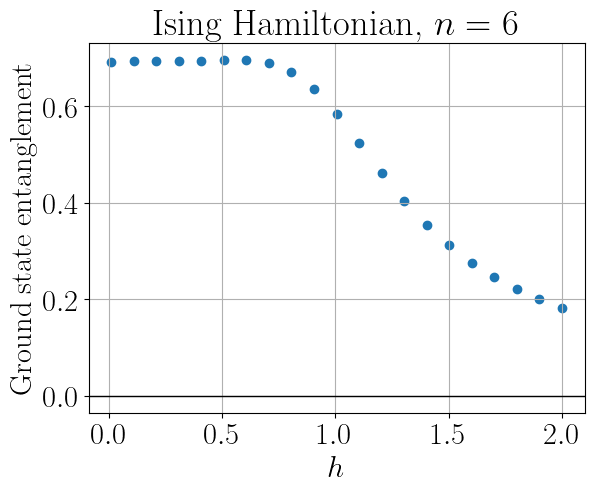

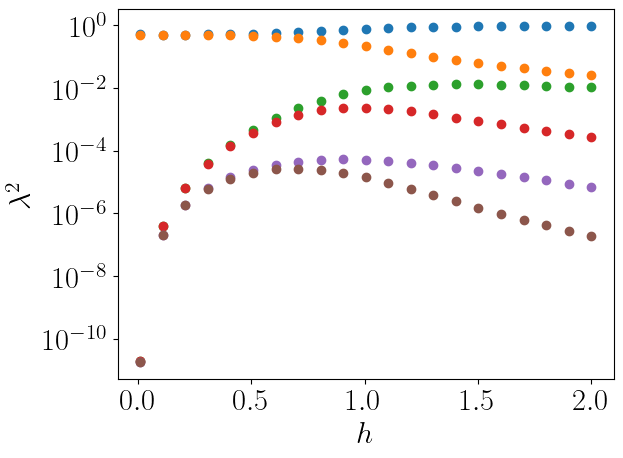

In [19]:
plt.scatter(hs, vn_ents)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel(r"$h$")
plt.ylabel(r"Ground state entanglement")
plt.title("Ising Hamiltonian, $n=%d$" %N )
plt.grid()
plt.show()

# for i in range(2**int(N/2)):
for i in range(6):#2**int(N/2)):
    plt.scatter(hs, array(lambdas_gs).T[i])
plt.xlabel(r"$h$")
plt.ylabel(r"$\lambda^2$")
plt.yscale("log")
plt.show()

In [20]:
N = 6
h = 0.5

H = ising_ham(N, h)
# H = rand_ham(N)
# vec = sum([kron(vec, vec) for vec in eye(2**int(N/2))])/sqrt(2**(N/2))
# H = eye(2**N) - outer(vec, vec)
# H = diag(arange(1, 2**N + 1)) - outer(vec, vec)
E_gs, E_ex = eigh(H)[0][0:2]

In [23]:
L = 4
n_runs = 5
R_min = 2
R_max = 2
options = {"maxiter": 300}#, "ftol": 1e-9
energies = []
lambdas = []
for R in range(R_min, R_max + 1):
    print("R =", R)
    energies_r = []
    lambdas_r = []
    for i in range(n_runs):
        print("i = %d" %i)
        fvals, optimization_result = do_vqe(H, L, R, options=options)
        # fvals, optimization_result = do_vqe_orth(H, L, R, options=options)
        print()
        print("error: %f" %(optimization_result.fun - E_gs))
        print("lambdas:", optimization_result.x[-R:])
        print()
        energies_r.append(optimization_result.fun)
        lambdas_r.append(optimization_result.x[-R:])
    # print("minimum error: %f                                     " %(min(energies_r) - E_gs))
    # print("lambdas:", lambdas_r[np.argmin(energies_r)])
    print()
    energies.append(energies_r)
    lambdas.append(lambdas_r)

R = 2
i = 0
Iteration: 155 | Function value: -6.381630
error: 0.003065
lambdas: [0.58558706 0.41441294]

i = 1
Iteration: 251 | Function value: -6.381749
error: 0.002945
lambdas: [0.57590447 0.42409553]

i = 2
Iteration: 117 | Function value: -6.381774
error: 0.002921
lambdas: [0.44509817 0.55490183]

i = 3
Iteration: 160 | Function value: -6.381739
error: 0.002956
lambdas: [0.58601444 0.41398556]

i = 4
Iteration: 128 | Function value: -6.381731
error: 0.002964
lambdas: [0.4117646 0.5882354]




In [220]:
U, S, Vh = svd(vec_gs.reshape(2**int(N/2), 2**int(N/2)))

r = 3
S = concatenate([S[:r], [0]*(2**int(N/2) - r)])

vec_gs_trunc = (U@diag(S)@Vh).reshape(-1)

norm(vec_gs - vec_gs_trunc)

0.01708041788240135

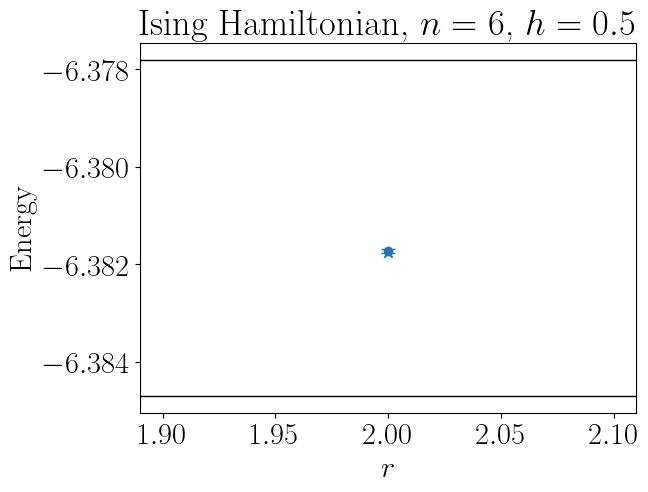

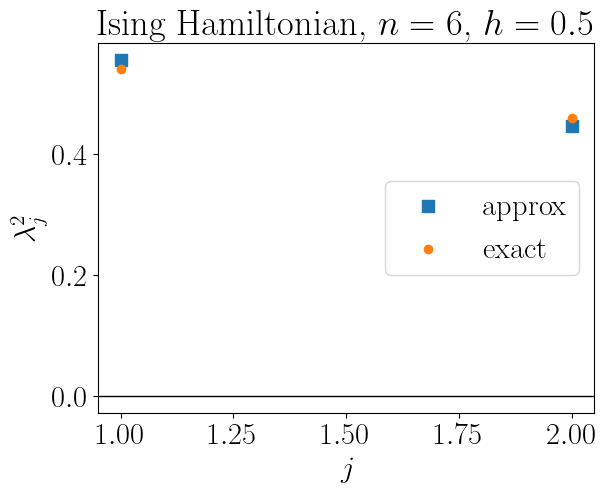

In [24]:
plt.scatter(arange(R_min, R_max + 1), np.min(energies, axis=1), marker="x", )
plt.errorbar(arange(R_min, R_max + 1), np.mean(energies, axis=1), yerr=np.std(energies, axis=1), marker="o", capsize=5)
plt.axhline(E_gs, color="black", linewidth=1)
plt.axhline(E_ex, color="black", linewidth=1)
# plt.axhline((vec_gs_trunc.conj().T@H@vec_gs_trunc).real, color="green", linewidth=1)
plt.xlabel(r"$r$")
plt.ylabel(r"Energy")
plt.title("Ising Hamiltonian, $n=%d$, $h=%.1f$" %(N, h))
# plt.title("Random Hamiltonian, $n=%d$" %N)
plt.show()

vec_gs = eigh(H)[1][:,0]
dm_gs = outer(vec_gs, vec_gs.conj().T)
dm_gs_red = partial_trace(dm_gs)
lambdas_gs = eigh(dm_gs_red)[0][::-1]
# plt.scatter(arange(1, 2**(N/2) + 1), lambdas_gs)
plt.scatter(arange(1, R_max + 1), np.sort(lambdas[-1][np.argmin(energies[-1])])[::-1], s=75, marker="s", label="approx")
plt.scatter(arange(1, R_max + 1), lambdas_gs[:R_max], label="exact")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j^2$")
plt.title("Ising Hamiltonian, $n=%d$, $h=%.1f$" %(N, h))
plt.legend()
# plt.yscale("log")
plt.show()

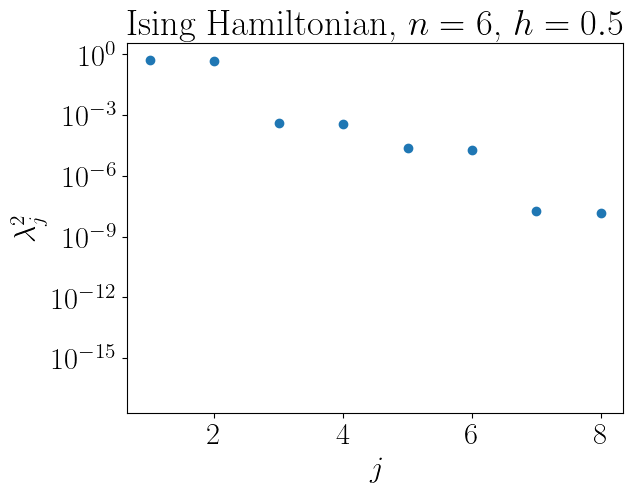

In [137]:
vec_gs = eigh(H)[1][:,0]
dm_gs = outer(vec_gs, vec_gs.conj().T)
dm_gs_red = partial_trace(dm_gs)
lambdas_gs = eigh(dm_gs_red)[0][::-1]
plt.scatter(arange(1, 2**(N/2) + 1), lambdas_gs)
# plt.scatter(arange(1, R_max + 1), np.sort(lambdas[-1][np.argmin(energies[-1])])[::-1], s=75, marker="s", label="approx")
# plt.scatter(arange(1, R_max + 1), lambdas_gs[:R_max], label="exact")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j^2$")
plt.title("Ising Hamiltonian, $n=%d$, $h=%.1f$" %(N, h))
# plt.legend()
plt.yscale("log")
plt.show()

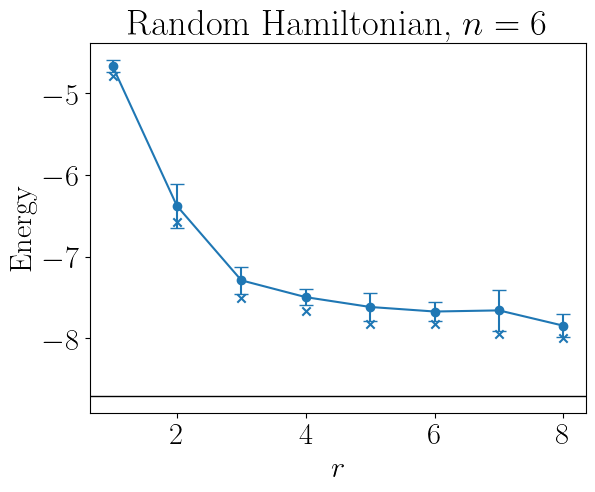

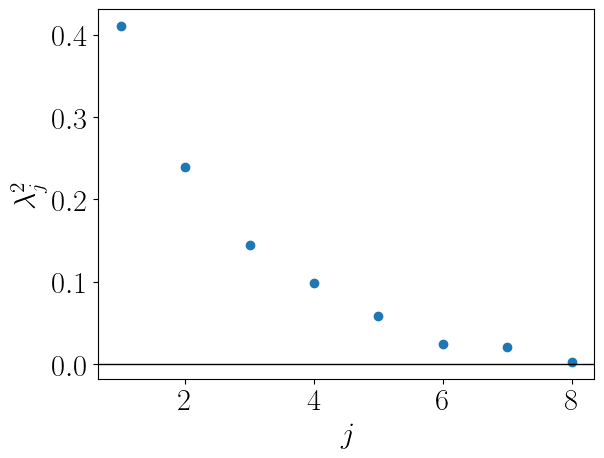

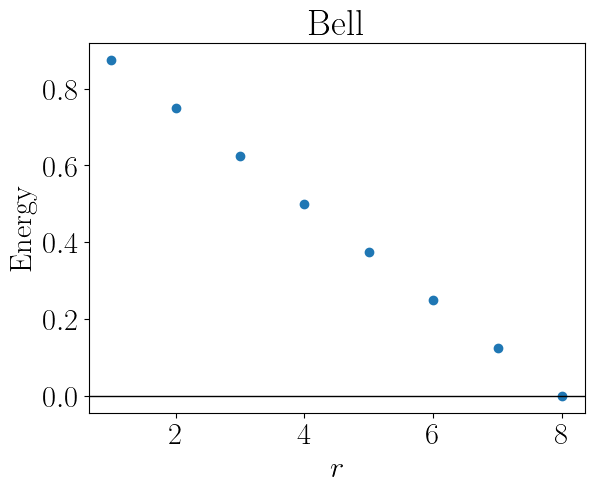

# old, unfinished, unused

In [66]:
### Bell ham

# vec = sum([kron(vec, vec) for vec in eye(2**int(N/2))])/sqrt(2**(N/2))
# H = eye(2**N) - outer(vec, vec)

In [67]:
### MPS approximation

# U, S, Vh = svd(vec_gs.reshape(2**int(N/2), 2**int(N/2)))

# r = 3
# S = concatenate([S[:r], [0]*(2**int(N/2) - r)])

# vec_gs_trunc = (U@diag(S)@Vh).reshape(-1)

# norm(vec_gs - vec_gs_trunc)